# Loads

In [8]:
pip install tqdm

In [9]:
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm  # Importar tqdm

import os
import pandas as pd
import json

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.autograd import Variable
from torch.optim import Adam, SGD, NAdam
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler


import torchvision
from torchvision import models, transforms
from torchvision.io import read_image

from torchsummary import summary

import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm  # Importar tqdm

import os
import pandas as pd
import json

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.autograd import Variable
from torch.optim import Adam, SGD, NAdam
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler


import torchvision
from torchvision import models, transforms
from torchvision.io import read_image

from torchsummary import summary

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from PIL import Image
import zipfile


from PIL import Image
import zipfile

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The model will be running on", device, "device")

The model will be running on cuda:0 device


In [11]:
# Clear existing files or directories from previous runs
!rm -f -r "/content/images"
!rm -f "/content/module_metadata.json"

# Define paths for download and extraction
repo_path = "/content/InfraredSolarModules/"
zip_path = "/content/2020-02-14_InfraredSolarModules.zip"
extract_path = "/content"

# Clone the repository and extract the zip file
!git clone https://github.com/RaptorMaps/InfraredSolarModules.git $repo_path
!mv "$repo_path/2020-02-14_InfraredSolarModules.zip" $extract_path
!unzip -uq $zip_path -d $extract_path

# Move images folder to the root directory
image_folder_path = "/content/InfraredSolarModules/images"
!mv $image_folder_path $extract_path

# Move module_metadata.json to the root directory
metadata_file_path = "/content/InfraredSolarModules/module_metadata.json"
!mv $metadata_file_path $extract_path

# Verify the final structure
!ls /content


fatal: destination path '/content/InfraredSolarModules' already exists and is not an empty directory.
mv: cannot stat '/content/InfraredSolarModules//2020-02-14_InfraredSolarModules.zip': No such file or directory
2020-02-14_InfraredSolarModules.zip  InfraredSolarModules  module_metadata.json
images				     __MACOSX		   sample_data


In [12]:
# Path to metadata JSON file
metadata_path = '/content/module_metadata.json'

# Load metadata
with open(metadata_path, 'r') as f:
    metadata = json.load(f)

# Convert metadata to DataFrame
df = pd.DataFrame.from_dict(metadata, orient='index')

# a)

In [ ]:
df_binary = df.copy()
df_binary['anomaly_class'] = df_binary['anomaly_class'].apply(
    lambda x: 1 if x.lower() != 'no-anomaly' else 0
)

# Display DataFrame details
print("*************** Binary Classification DataFrame ***************")
print(df_binary.head())
print("Total rows:", df_binary.shape[0])

train_ratio = 0.9
train_data, test_data = train_test_split(df_binary, test_size=(1-train_ratio), train_size=train_ratio, random_state=2, stratify=df_binary['anomaly_class'])

train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)


*************** Binary Classification DataFrame ***************
         image_filepath  anomaly_class
13357  images/13357.jpg              0
13356  images/13356.jpg              0
19719  images/19719.jpg              0
11542  images/11542.jpg              0
11543  images/11543.jpg              0
Total rows: 20000


In [ ]:
"""
train_data, test_data=train_test_split(df_binary, test_size=0.15,train_size=0.85, random_state=2, stratify=df_binary["anomaly_class"])
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)
"""



'\ntrain_data, test_data=train_test_split(df_binary, test_size=0.15,train_size=0.85, random_state=2, stratify=df_binary["anomaly_class"])\ntrain_data.reset_index(drop=True, inplace=True)\ntest_data.reset_index(drop=True, inplace=True)\n'

ESTÁ IGUAL AO DO VITOR TEMOS QUE MUDAR DAQUI PARA BAIXO

In [ ]:
class MyImageDataset(data.Dataset):
    def __init__(self, metadata, transform=None, img_mode="L"):

        self.img_labels = metadata["anomaly_class"].values
        self.img_paths = metadata["image_filepath"].values
        self.transform = transform
        self.img_mode = img_mode

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):

        try:
            img_path = self.img_paths[idx]

            # Ensure the image file exists
            if not os.path.exists(img_path):
                raise FileNotFoundError(f"Image file not found: {img_path}")

            # Open and convert the image
            image = Image.open(img_path).convert(self.img_mode)
            label = self.img_labels[idx]

            # Apply transformations if specified
            if self.transform:
                image = self.transform(image)

            return image, torch.tensor(label, dtype=torch.long)

        except Exception as e:
            raise RuntimeError(f"Error loading sample at index {idx}: {e}")


'\nclass MyImageDataset(data.Dataset):\n    def __init__(self, metadata, transform=None):\n        self.img_labels = metadata["anomaly_class"].values\n        self.img_paths = metadata["image_filepath"].values\n        self.transform = transform\n\n    def __len__(self):\n        return len(self.img_labels)\n\n    def __getitem__(self, idx):#posteriormente o dataloader vai passar por todos os idx\n        img_path = self.img_paths[idx]\n        image = Image.open(img_path).convert("L") # Abrir a imagem como RGB\n        label = self.img_labels[idx]\n\n        if self.transform:\n            image = self.transform(image)\n\n        return image, torch.tensor(label, dtype=torch.long)\n'

In [ ]:
# Transformações
train_transform = transforms.Compose([
    transforms.RandomRotation(10),       # Random rotation
    transforms.RandomHorizontalFlip(),   # Random horizontal flip
    transforms.RandomCrop((40, 24), padding=1),  # Random crop with padding
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Color jitter
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Testing transform without augmentation
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
# Datasets
train_dataset = MyImageDataset(metadata=train_data, transform=train_transform)
test_dataset = MyImageDataset(metadata=test_data, transform=test_transform)

# DataLoaders
batch_size = 16
train_loader = data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)



torch.Size([1, 40, 24])


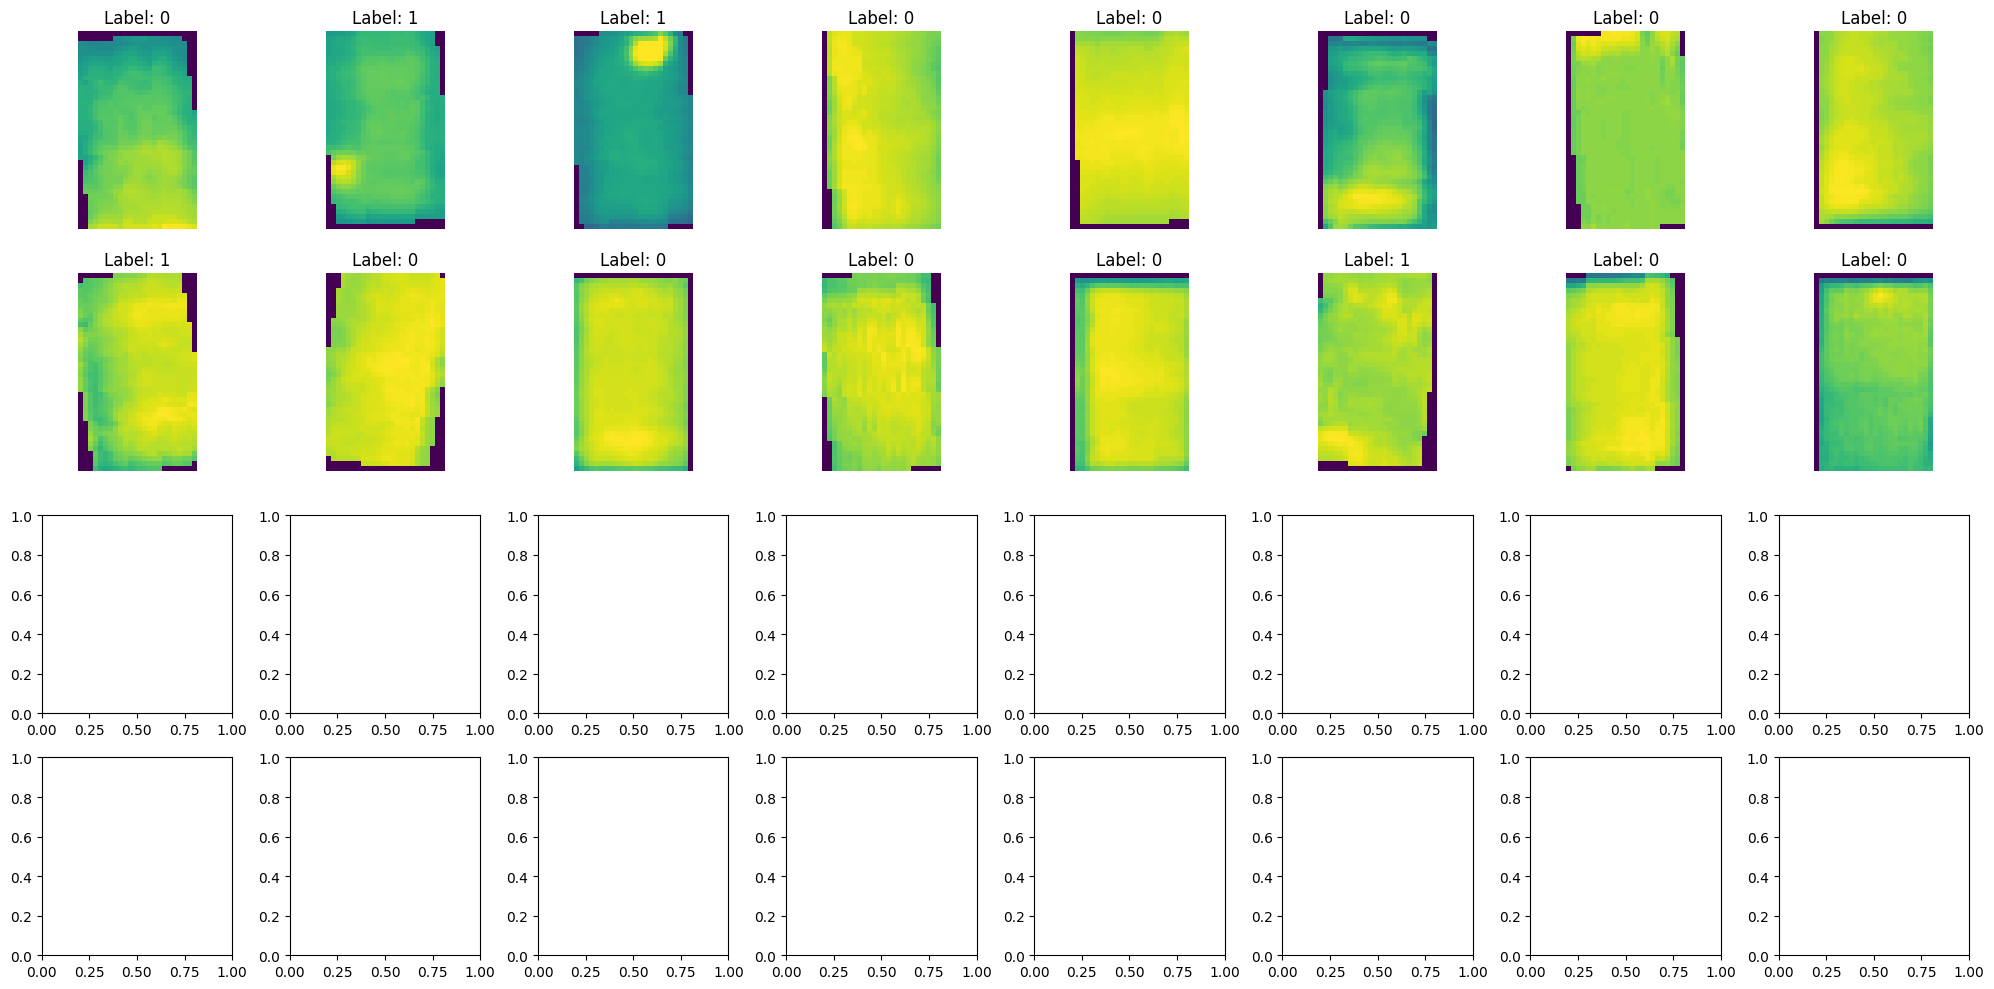

In [ ]:
# Obtém um batch de imagens, seus rótulos e os caminhos
images, labels = next(iter(train_loader))  # Pega o primeiro batch

# Desfazendo a normalização para as imagens
images = images * 0.5 + 0.5  # Inverte a normalização, para voltar ao intervalo [0, 1]

# Cria uma figura com múltiplos subplots
fig, axes = plt.subplots(4, 8, figsize=(20, 10))  # 4 linhas e 8 colunas
axes = axes.flatten()  # Para facilitar o acesso aos eixos (axes)

# Loop para exibir as 32 primeiras imagens do batch
for i in range(len(images)):
    image = images[i]  # Pega a i-ésima imagem do batch
    image_pil = transforms.ToPILImage()(image)  # Converte o tensor para uma imagem PIL

    # Exibe a imagem
    axes[i].imshow(image_pil)
    axes[i].set_title(f"Label: {labels[i].item()}")  # Exibe o rótulo e o caminho do arquivo
    axes[i].axis('off')  # Remove os eixos para uma exibição mais limpa

print(images[0].shape)
plt.tight_layout()  # Ajusta o layout para que as imagens não se sobreponham
plt.show()







In [ ]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolutional and pooling layers with kernel size 5x5 for the first two layers, 3x3 for the third layer
        self.conv1 = nn.Conv2d(1, 128, 3)  # Kernel size 5x5
        self.bn1 = nn.BatchNorm2d(128)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(128, 256, 3)  # Kernel size 5x5
        self.bn2 = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(2, 2)  # Max pool layer (2x2)

        self.conv3 = nn.Conv2d(256, 512, 3)  # Kernel size 3x3 (adjusted for valid output size)
        self.bn3 = nn.BatchNorm2d(512)

        self.dropout_conv = nn.Dropout2d(0.2)

        # Calculating the correct input size for the fully connected layer
        # Initial    : (40, 24)
        # After conv1: (38, 22)
        # After pool1: (19, 11)
        # After conv2: (17, 9)
        # After pool2: (8, 4)
        # After conv3: (6, 2)

        self.fc1 = nn.Linear(512 * 6 * 2, 1024)  # Increased to 2048 neurons
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(1024, 512)         # Increased to 1024 neurons
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(512, 2)          # Increased to 512 neurons

    def forward(self, x):
        # First convolutional layer, ReLU, and pooling
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout_conv(x)  # Dropout2d after pooling
        x = F.relu(self.bn3(self.conv3(x)))

        # Flatten the output for the fully connected layer
        x = torch.flatten(x, 1)  # Flatten to [batch_size, 256*5*1]

        # Fully connected layers with ReLU and dropout
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)

        return x


model = Network()
# Define the loss function
loss_fn = nn.CrossEntropyLoss().to(device)

# Define the optimizer
#optimizer = torch.optim.SGD(model.parameters(), lr=0.0025, momentum=0.9, weight_decay=1e-4)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

In [13]:
# Function to save the model
def saveModel(model:nn.Module, path):
    torch.save(model.state_dict(), path)

# Training function. We simply have to loop over our data iterator and feed the inputs to the network and optimize.
def train(model: torch.nn.Module,
          dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          device: torch.device,
          num_epochs,
          path_model,
          verbatim):
    model.train()
    model.to(device)
    best_accuracy = 0.0
    best_loss = 0.0
    best_epoch = 0
    for epoch in tqdm(range(num_epochs), desc="Epochs", unit="epoch"):  # Adicionando a barra de progresso para os epochs

        train_acc = 0.0
        train_loss = 0.0
        for ibatch, (images, labels) in enumerate(dataloader):  # Adicionando a barra de progresso para os batches

            # get the inputs
            images = images.to(device)
            labels = labels.to(device)

            # 1. Forward pass
            y_pred = model(images)
            y_pred = y_pred.squeeze(dim=1)

            # 2. Calculate  and accumulate loss
            loss = loss_fn(y_pred, labels)
            train_loss += loss.item()

            # 3. Optimizer zero grad
            optimizer.zero_grad()

            # 4. Loss backward
            loss.backward()

            # 5. Optimizer step
            optimizer.step()

            # Calculate and accumulate accuracy metric across all batches
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            train_acc += (y_pred_class == labels).sum().item()/len(y_pred)

        # Adjust metrics to get average loss and accuracy per batch
        train_loss = train_loss / len(dataloader)
        train_acc = train_acc / len(dataloader)

        # we want to save the model if the accuracy is the best


        if train_acc > best_accuracy:
            path = str(path_model)
            saveModel(model, path = path)
            best_loss = train_loss
            best_accuracy = train_acc
            best_epoch = epoch
            if verbatim:
              print('Best Epoch #', epoch,' Loss=', best_loss, " Accu=", best_accuracy )

    return best_loss, best_accuracy, best_epoch

In [14]:
# Function to test the model with the test dataset and print the accuracy for the test images
def test(model: torch.nn.Module,
         dataloader: torch.utils.data.DataLoader,
         loss_fn: torch.nn.Module,
         device: torch.device,
         verbatim = True):

    # Put model in eval mode
    model.eval()
    model.to(device)
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    pred_labels = []
    with torch.no_grad():
        for data in dataloader:

            # get the inputs
            images, labels = data
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))

            # 1. run the model on the test set to predict labels
            y_pred = model(images)

            # 2. Calculate and accumulate loss
            loss = loss_fn(y_pred, labels)
            test_loss += loss.item()

            # 3. Calculate and accumulate accuracy
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            test_acc += (y_pred_class == labels).sum().item()/len(y_pred)
            pred_labels = y_pred_class.tolist()

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    if verbatim:
      print("Loss =", test_loss, "  Accuracy=", test_acc)
    return pred_labels, test_loss, test_acc


In [ ]:
if __name__ == "__main__":

    model = model.to(device)

    # Build our model
    best_loss, best_accuracy, best_epoch = train(model=model,
                                                    dataloader=train_loader,
                                                    loss_fn=loss_fn,
                                                    optimizer=optimizer,
                                                    device=device,
                                                    num_epochs = 170,
                                                    path_model = str("./myModel_best_A.pth"),
                                                    verbatim = True)

Epochs:   1%|          | 1/100 [00:21<35:48, 21.70s/epoch]

Best Epoch # 0  Loss= 0.5830068894094891  Accu= 0.6832222222222222


Epochs:   2%|▏         | 2/100 [00:43<35:24, 21.68s/epoch]

Best Epoch # 1  Loss= 0.46680253664652505  Accu= 0.7801666666666667


Epochs:   3%|▎         | 3/100 [01:05<35:01, 21.67s/epoch]

Best Epoch # 2  Loss= 0.4298453078005049  Accu= 0.8058888888888889


Epochs:   4%|▍         | 4/100 [01:26<34:38, 21.66s/epoch]

Best Epoch # 3  Loss= 0.4081625664830208  Accu= 0.8148888888888889


Epochs:   5%|▌         | 5/100 [01:48<34:11, 21.59s/epoch]

Best Epoch # 4  Loss= 0.3877990692920155  Accu= 0.8276111111111111


Epochs:   6%|▌         | 6/100 [02:09<33:49, 21.59s/epoch]

Best Epoch # 5  Loss= 0.3717162306308746  Accu= 0.8367222222222223


Epochs:   7%|▋         | 7/100 [02:31<33:28, 21.60s/epoch]

Best Epoch # 6  Loss= 0.36202601963943903  Accu= 0.8457222222222223


Epochs:   8%|▊         | 8/100 [02:53<33:10, 21.63s/epoch]

Best Epoch # 7  Loss= 0.3558795263138082  Accu= 0.8473888888888889


Epochs:   9%|▉         | 9/100 [03:14<32:46, 21.61s/epoch]

Best Epoch # 8  Loss= 0.3426227692597442  Accu= 0.8531111111111112


Epochs:  10%|█         | 10/100 [03:36<32:24, 21.60s/epoch]

Best Epoch # 9  Loss= 0.3340263299511539  Accu= 0.8575555555555555


Epochs:  12%|█▏        | 12/100 [04:19<31:43, 21.64s/epoch]

Best Epoch # 11  Loss= 0.32472748959064485  Accu= 0.8628888888888889


Epochs:  13%|█▎        | 13/100 [04:41<31:25, 21.67s/epoch]

Best Epoch # 12  Loss= 0.3189107125169701  Accu= 0.8677222222222222


Epochs:  14%|█▍        | 14/100 [05:02<31:04, 21.68s/epoch]

Best Epoch # 13  Loss= 0.3135161369972759  Accu= 0.8687222222222222


Epochs:  15%|█▌        | 15/100 [05:24<30:40, 21.65s/epoch]

Best Epoch # 14  Loss= 0.3064015870061186  Accu= 0.8703333333333333


Epochs:  16%|█▌        | 16/100 [05:46<30:18, 21.65s/epoch]

Best Epoch # 15  Loss= 0.3014935211042563  Accu= 0.8727222222222222


Epochs:  17%|█▋        | 17/100 [06:07<29:59, 21.68s/epoch]

Best Epoch # 16  Loss= 0.30144369392262566  Accu= 0.8750555555555556


Epochs:  18%|█▊        | 18/100 [06:29<29:37, 21.67s/epoch]

Best Epoch # 17  Loss= 0.29167660941018  Accu= 0.8816111111111111


Epochs:  20%|██        | 20/100 [07:12<28:51, 21.64s/epoch]

Best Epoch # 19  Loss= 0.2863163690765699  Accu= 0.883


Epochs:  22%|██▏       | 22/100 [07:56<28:10, 21.67s/epoch]

Best Epoch # 21  Loss= 0.27903990331954426  Accu= 0.8863333333333333


Epochs:  23%|██▎       | 23/100 [08:17<27:49, 21.68s/epoch]

Best Epoch # 22  Loss= 0.2753701916171445  Accu= 0.8878333333333334


Epochs:  24%|██▍       | 24/100 [08:39<27:28, 21.69s/epoch]

Best Epoch # 23  Loss= 0.27088164631856815  Accu= 0.8898888888888888


Epochs:  25%|██▌       | 25/100 [09:01<27:06, 21.69s/epoch]

Best Epoch # 24  Loss= 0.26912738126019636  Accu= 0.8911666666666667


Epochs:  26%|██▌       | 26/100 [09:23<26:46, 21.70s/epoch]

Best Epoch # 25  Loss= 0.2626484841141436  Accu= 0.8950555555555556


Epochs:  28%|██▊       | 28/100 [10:06<26:01, 21.69s/epoch]

Best Epoch # 27  Loss= 0.25916436034275425  Accu= 0.8953888888888889


Epochs:  30%|███       | 30/100 [10:49<25:14, 21.64s/epoch]

Best Epoch # 29  Loss= 0.25559684417314  Accu= 0.8969444444444444


Epochs:  31%|███       | 31/100 [11:11<24:55, 21.67s/epoch]

Best Epoch # 30  Loss= 0.24840800406369898  Accu= 0.8991111111111111


Epochs:  32%|███▏      | 32/100 [11:32<24:34, 21.69s/epoch]

Best Epoch # 31  Loss= 0.24886650116244952  Accu= 0.9002777777777777


Epochs:  33%|███▎      | 33/100 [11:54<24:12, 21.67s/epoch]

Best Epoch # 32  Loss= 0.24480910383827156  Accu= 0.9022222222222223


Epochs:  35%|███▌      | 35/100 [12:37<23:29, 21.68s/epoch]

Best Epoch # 34  Loss= 0.24027235542734465  Accu= 0.9034444444444445


Epochs:  37%|███▋      | 37/100 [13:21<22:44, 21.65s/epoch]

Best Epoch # 36  Loss= 0.24027669313384428  Accu= 0.9038888888888889


Epochs:  38%|███▊      | 38/100 [13:43<22:28, 21.75s/epoch]

Best Epoch # 37  Loss= 0.23656465076903502  Accu= 0.9062777777777777


Epochs:  40%|████      | 40/100 [14:26<21:41, 21.70s/epoch]

Best Epoch # 39  Loss= 0.2281227261275053  Accu= 0.9075


Epochs:  41%|████      | 41/100 [14:48<21:20, 21.70s/epoch]

Best Epoch # 40  Loss= 0.22860479573284587  Accu= 0.9097777777777778


Epochs:  43%|████▎     | 43/100 [15:31<20:35, 21.68s/epoch]

Best Epoch # 42  Loss= 0.221244699191716  Accu= 0.9124444444444444


Epochs:  49%|████▉     | 49/100 [17:40<18:21, 21.59s/epoch]

Best Epoch # 48  Loss= 0.21581618747115136  Accu= 0.9140555555555555


Epochs:  51%|█████     | 51/100 [18:24<17:37, 21.58s/epoch]

Best Epoch # 50  Loss= 0.21010463714930747  Accu= 0.9151666666666667


Epochs:  53%|█████▎    | 53/100 [19:07<16:55, 21.60s/epoch]

Best Epoch # 52  Loss= 0.2102157014326917  Accu= 0.9161111111111111


Epochs:  54%|█████▍    | 54/100 [19:28<16:34, 21.62s/epoch]

Best Epoch # 53  Loss= 0.2080180047419336  Accu= 0.9176666666666666


Epochs:  56%|█████▌    | 56/100 [20:12<15:52, 21.65s/epoch]

Best Epoch # 55  Loss= 0.20693437629772557  Accu= 0.9186111111111112


Epochs:  59%|█████▉    | 59/100 [21:16<14:44, 21.58s/epoch]

Best Epoch # 58  Loss= 0.2038224189115895  Accu= 0.9199444444444445


Epochs:  62%|██████▏   | 62/100 [22:21<13:41, 21.62s/epoch]

Best Epoch # 61  Loss= 0.19858592094977698  Accu= 0.9222222222222223


Epochs:  66%|██████▌   | 66/100 [23:48<12:16, 21.66s/epoch]

Best Epoch # 65  Loss= 0.1973522884307636  Accu= 0.9233333333333333


Epochs:  68%|██████▊   | 68/100 [24:31<11:32, 21.65s/epoch]

Best Epoch # 67  Loss= 0.19260267771201  Accu= 0.9258888888888889


Epochs:  71%|███████   | 71/100 [25:36<10:26, 21.61s/epoch]

Best Epoch # 70  Loss= 0.1899161305717296  Accu= 0.9262222222222222


Epochs:  73%|███████▎  | 73/100 [26:19<09:44, 21.67s/epoch]

Best Epoch # 72  Loss= 0.18764244636727703  Accu= 0.9278888888888889


Epochs:  77%|███████▋  | 77/100 [27:46<08:20, 21.77s/epoch]

Best Epoch # 76  Loss= 0.18480139424072373  Accu= 0.9281666666666667


Epochs:  78%|███████▊  | 78/100 [28:08<07:58, 21.74s/epoch]

Best Epoch # 77  Loss= 0.18516766655362316  Accu= 0.9293333333333333


Epochs:  82%|████████▏ | 82/100 [29:35<06:31, 21.73s/epoch]

Best Epoch # 81  Loss= 0.1828312956272728  Accu= 0.9293888888888889


Epochs:  85%|████████▌ | 85/100 [30:40<05:26, 21.74s/epoch]

Best Epoch # 84  Loss= 0.18080155381311974  Accu= 0.9306666666666666


Epochs:  91%|█████████ | 91/100 [32:50<03:14, 21.62s/epoch]

Best Epoch # 90  Loss= 0.1743188572542535  Accu= 0.9318888888888889


Epochs:  92%|█████████▏| 92/100 [33:11<02:53, 21.70s/epoch]

Best Epoch # 91  Loss= 0.1704873509750598  Accu= 0.9334444444444444


Epochs:  97%|█████████▋| 97/100 [35:00<01:04, 21.65s/epoch]

Best Epoch # 96  Loss= 0.16975523596174188  Accu= 0.934


Epochs:  98%|█████████▊| 98/100 [35:21<00:43, 21.63s/epoch]

Best Epoch # 97  Loss= 0.16881555987687574  Accu= 0.9342222222222222


Epochs:  99%|█████████▉| 99/100 [35:43<00:21, 21.63s/epoch]

Best Epoch # 98  Loss= 0.1689965299645232  Accu= 0.9352222222222222


Epochs: 100%|██████████| 100/100 [36:05<00:00, 21.65s/epoch]

Best Epoch # 99  Loss= 0.16520258730153242  Accu= 0.9357222222222222


In [ ]:
y_pred, test_loss, test_acc  = test(model=model,
                                    dataloader=test_loader,
                                    loss_fn=loss_fn,
                                    device=device,
                                    verbatim = True)

Loss = 0.2049230250851251   Accuracy= 0.9515


In [ ]:
# Load the model
model = Network()
model = model.to(device)

# Path to the saved model
saved_model_path = "./myModel_best_A-9535.pth"

# Load the model's state dictionary
checkpoint = torch.load(saved_model_path, map_location=device)
model.load_state_dict(checkpoint)

# Set model to evaluation mode if you're testing/inferencing
model.eval()

y_pred, test_loss, test_acc  = test(model=model,
                                    dataloader=test_loader,
                                    loss_fn=loss_fn,
                                    device=device,
                                    verbatim = True)

<ipython-input-54-0ab62ce3ef41>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(saved_model_path, map_location=device)


Loss = 0.2049230250851251   Accuracy= 0.9515


# b)

In [15]:
# Binary Classification DataFrame
df_anomaly = df.copy()

# Filter out the "No-Anomaly" class
df_anomaly = df_anomaly[df_anomaly["anomaly_class"] != "No-Anomaly"]

# Map string labels to numerical labels
df_anomaly['anomaly_class'] = df_anomaly['anomaly_class'].apply(
    lambda x: 0 if x == 'Cell'
              else 1 if x == 'Cell-Multi'
              else 2 if x == 'Cracking'
              else 3 if x == 'Hot-Spot'
              else 4 if x == 'Hot-Spot-Multi'
              else 5 if x == 'Shadowing'
              else 6 if x == 'Diode'
              else 7 if x == 'Diode-Multi'
              else 8 if x == 'Vegetation'
              else 9 if x == 'Soiling'
              else 10 if x == 'Offline-Module'
              else 11
)

# Print the class distribution
anomaly_counts = df_anomaly['anomaly_class'].value_counts()
print("Counts of each anomaly type:")
print(anomaly_counts)




Counts of each anomaly type:
anomaly_class
0     1877
8     1639
6     1499
1     1288
5     1056
2      940
10     827
3      249
4      246
9      204
7      175
Name: count, dtype: int64


In [16]:
train_ratio_b = 0.9
train_data_b, test_data_b = train_test_split(df_anomaly, test_size=(1 - train_ratio_b), train_size=train_ratio_b, random_state=2, stratify=df_anomaly['anomaly_class'])

train_data_b.reset_index(drop=True, inplace=True)
test_data_b.reset_index(drop=True, inplace=True)

In [17]:

transform_augmentation_1 = transforms.Compose([
    transforms.RandomRotation(10),       # Random rotation
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),   # Random horizontal flip
    #transforms.RandomCrop((40, 24), padding=1),  # Random crop with padding
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Color jitter
    transforms.ToTensor(),
])

transform_augmentation_2 = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),   # Random horizontal flip
    transforms.RandomRotation(5),       # Random rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Color jitter
    transforms.ToTensor(),
])

transform_augmentation_3 = transforms.Compose([
    transforms.RandomVerticalFlip(p=1),
    transforms.RandomRotation(5),       # Random rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Color jitter
    transforms.ToTensor(),
])

transform_augmentation_4 = transforms.Compose([
    transforms.RandomVerticalFlip(p=1),
    transforms.RandomHorizontalFlip(p=1),
    transforms.RandomRotation(5),       # Random rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Color jitter
    transforms.ToTensor(),
])

train_transform = transforms.Compose([
    #transforms.RandomRotation(10),       # Random rotation
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomHorizontalFlip(),
    #transforms.RandomCrop((40, 24), padding=1),  # Random crop with padding
    #transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Color jitter
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Testing transform without augmentation
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [18]:
train_data_b_counts = train_data_b['anomaly_class'].value_counts()
print("Counts of each anomaly type:")
print(train_data_b_counts)
print("Size:", len(train_data_b), "\n")

# Datasets
train_data_b_balanced = train_data_b.copy()

largest_class_count = train_data_b_counts.max()
ratios = largest_class_count / train_data_b_counts
max_ratio = 4
ratios = np.minimum(ratios, max_ratio)

ratios_sorted = ratios.sort_index()
ratios_matrix=[]

for label, ratio in ratios_sorted.items():
    ratios_matrix.append([label, ratio])
ratios_matrix[0][1]+=0.1
print(ratios_matrix)



directory = "/content/images_b"
if os.path.exists(directory):
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        try:
            if os.path.isdir(file_path):
                shutil.rmtree(file_path)
            else:
                os.remove(file_path)
        except Exception as e:
            print(f"Error deleting file {file_path}: {e}")
else:
    os.makedirs(directory, exist_ok=True)



for i in range(len(train_data_b)):
    # Get the row for the current sample
    row = train_data_b.iloc[i]
    image_path = row["image_filepath"]  # Path to the image
    label = row["anomaly_class"]       # Corresponding label

    # Load the image using PIL
    image_pil = Image.open(image_path).convert("L")

    # Get the ratio for this class
    ratio = ratios_matrix[int(label)][1]

    # Split the ratio into integer and fractional parts
    int_part = int(ratio)  # Deterministic augmentations
    frac_part = ratio - int_part  # Fractional part for probabilistic augmentation

    # Perform deterministic augmentations
    for n in range(int_part-1):  # Subtract 1 because the original image already counts as 1
        if(int_part==1):
            transform_augmentation = transform_augmentation_1
        elif(int_part==2 and n==0):
            transform_augmentation = transform_augmentation_2
        elif(int_part==2 and n==1):
            transform_augmentation = transform_augmentation_3
        elif(int_part==3 and n==0):
            transform_augmentation = transform_augmentation_2
        elif(int_part==3 and n==1):
            transform_augmentation = transform_augmentation_3
        elif(int_part==3 and n==2):
            transform_augmentation = transform_augmentation_4
        elif(int_part==4 and n==0):
            transform_augmentation = transform_augmentation_1
        elif(int_part==4 and n==1):
            transform_augmentation = transform_augmentation_2
        elif(int_part==4 and n==2):
            transform_augmentation = transform_augmentation_3
        elif(int_part==4 and n==3):
            transform_augmentation = transform_augmentation_4

        transformed_image = transform_augmentation(image_pil)
        if isinstance(transformed_image, torch.Tensor):
            transformed_image = transforms.ToPILImage()(transformed_image)
        new_image_path = os.path.join(directory, f"transformed_image_{int(label)}_{i}_{n}.jpg")
        transformed_image.save(new_image_path, format="JPEG", quality=95)
        new_row = {"image_filepath": new_image_path, "anomaly_class": int(label)}
        train_data_b_balanced = pd.concat([train_data_b_balanced, pd.DataFrame([new_row])], ignore_index=True)

    # Perform probabilistic augmentation for the fractional part
    if random.random() < frac_part:  # Augment with probability equal to the fractional part
        transformed_image = transform_augmentation_1(image_pil)
        x=1
        if isinstance(transformed_image, torch.Tensor):
            transformed_image = transforms.ToPILImage()(transformed_image)
        new_image_path = os.path.join(directory, f"transformed_image_2_{int(label)}_{i}_{x}.jpg")
        x+=1
        transformed_image.save(new_image_path, format="JPEG", quality=95)
        new_row = {"image_filepath": new_image_path, "anomaly_class": int(label)}
        train_data_b_balanced = pd.concat([train_data_b_balanced, pd.DataFrame([new_row])], ignore_index=True)


train_data_b_balanced_counts = train_data_b_balanced['anomaly_class'].value_counts()
print("\nCounts of each anomaly type:")
print(train_data_b_balanced_counts)
print("Size:", len(train_data_b_balanced))

Counts of each anomaly type:
anomaly_class
0     1689
8     1475
6     1349
1     1159
5      950
2      846
10     744
3      224
4      222
9      184
7      158
Name: count, dtype: int64
Size: 9000 

[[0, 1.1], [1, 1.4572907679033649], [2, 1.99645390070922], [3, 4.0], [4, 4.0], [5, 1.7778947368421052], [6, 1.252038547071905], [7, 4.0], [8, 1.1450847457627118], [9, 4.0], [10, 2.2701612903225805]]

Counts of each anomaly type:
anomaly_class
0     1850
6     1701
1     1696
5     1694
2     1690
8     1689
10    1679
3      896
4      888
9      736
7      632
Name: count, dtype: int64
Size: 15151


In [19]:
class MyImageDataset_b(data.Dataset):
    def __init__(self, metadata, transform=None, img_mode="L"):

        self.img_labels = metadata["anomaly_class"].values
        self.img_paths = metadata["image_filepath"].values
        self.transform = transform
        self.img_mode = img_mode

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):

        try:
            img_path = self.img_paths[idx]

            # Ensure the image file exists
            if not os.path.exists(img_path):
                raise FileNotFoundError(f"Image file not found: {img_path}")

            # Open and convert the image
            image = Image.open(img_path).convert(self.img_mode)
            label = self.img_labels[idx]

            # Apply transformations if specified
            if self.transform:
                image = self.transform(image)

            return image, torch.tensor(label, dtype=torch.long)

        except Exception as e:
            raise RuntimeError(f"Error loading sample at index {idx}: {e}")

In [20]:
# DataLoaders
#train_dataset_b_balanced = MyImageDataset_b(metadata=train_data_b, transform=train_transform)
train_dataset_b_balanced = MyImageDataset_b(metadata=train_data_b_balanced, transform=train_transform)
test_dataset_b = MyImageDataset_b(metadata=test_data_b, transform=test_transform)

batch_size = 32
train_loader_b = data.DataLoader(dataset=train_dataset_b_balanced, batch_size=batch_size, shuffle=True)
test_loader_b = data.DataLoader(dataset=test_dataset_b, batch_size=batch_size, shuffle=False)

tensor(9)
torch.Size([1, 40, 24])


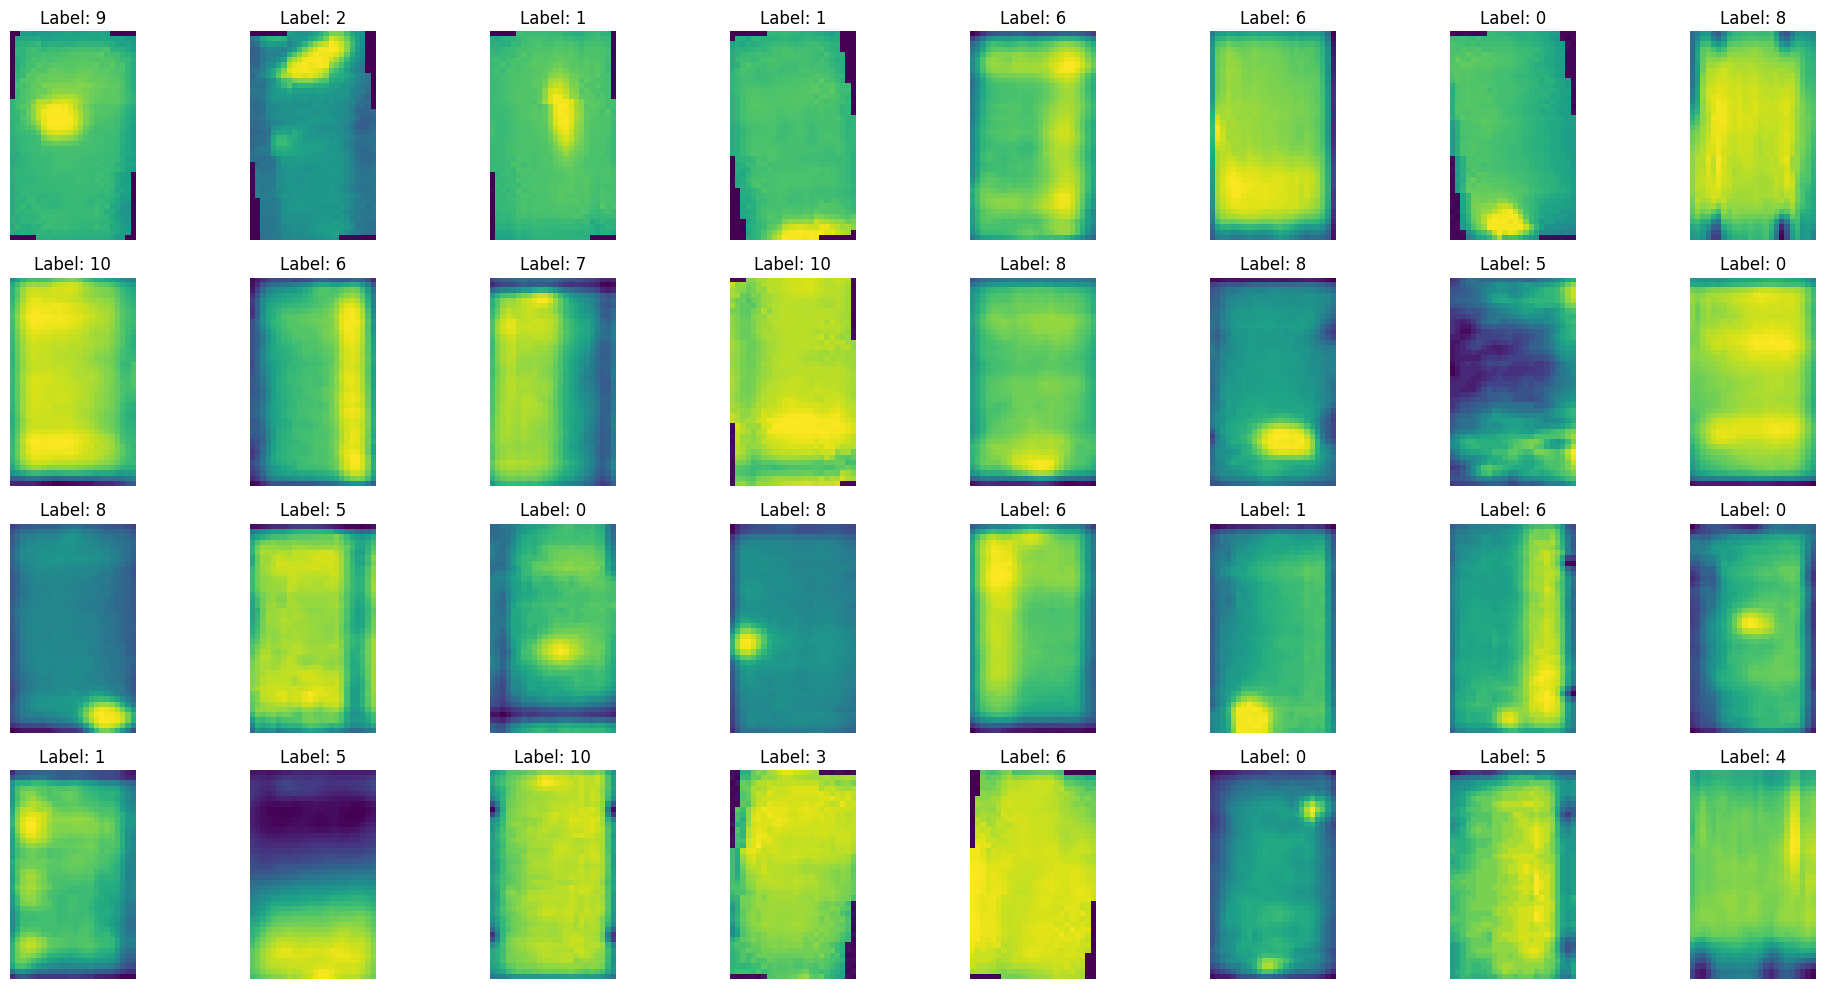

In [21]:
# Obtém um batch de imagens, seus rótulos e os caminhos
images_b, labels_b = next(iter(train_loader_b))  # Pega o primeiro batch
print(labels_b[0])

# Desfazendo a normalização para as imagens
images_b = images_b * 0.5 + 0.5  # Inverte a normalização, para voltar ao intervalo [0, 1]

# Cria uma figura com múltiplos subplots
fig, axes = plt.subplots(4, 8, figsize=(20, 10))  # 4 linhas e 8 colunas
axes = axes.flatten()  # Para facilitar o acesso aos eixos (axes)

# Loop para exibir as 32 primeiras imagens do batch
for i in range(len(images_b)):
    image = images_b[i]  # Pega a i-ésima imagem do batch
    image_pil = transforms.ToPILImage()(image)  # Converte o tensor para uma imagem PIL

    # Exibe a imagem
    axes[i].imshow(image_pil)
    axes[i].set_title(f"Label: {labels_b[i].item()}")  # Exibe o rótulo e o caminho do arquivo
    axes[i].axis('off')  # Remove os eixos para uma exibição mais limpa

print(images_b[0].shape)
plt.tight_layout()  # Ajusta o layout para que as imagens não se sobreponham
plt.show()

In [22]:
class Network_b(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolutional and pooling layers with kernel size 5x5 for the first two layers, 3x3 for the third layer
        self.conv1 = nn.Conv2d(1, 128, 3)
        self.bn1 = nn.BatchNorm2d(128)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(128, 256, 3)
        self.bn2 = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(2, 1)

        self.conv3 = nn.Conv2d(256, 512, 3)
        self.bn3 = nn.BatchNorm2d(512)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.conv4 = nn.Conv2d(512, 512, 3)  # Extra layer
        self.bn4 = nn.BatchNorm2d(512)

        self.dropout_conv = nn.Dropout2d(0.2)

        # Calculating the correct input size for the fully connected layer
        # Initial    : (40, 24)
        # After conv1: (38, 22)
        # After pool1: (19, 11)
        # After conv2: (17, 9)
        # After pool2: (16, 8)
        # After conv3: (14, 6)
        # After pool3: (7, 3)
        # After conv4: (5, 1)

        self.fc1 = nn.Linear(512 * 5 * 1, 2048)   # Increase neurons
        self.bn_fc1 = nn.BatchNorm1d(2048)        #  TIR
        self.dropout1 = nn.Dropout(0.4)           # Dropout

        self.fc2 = nn.Linear(2048, 1024)          # Add capacity
        self.bn_fc2 = nn.BatchNorm1d(1024)        # Batch normalization
        self.dropout2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(1024, 256)           # Add another layer
        self.dropout3 = nn.Dropout(0.5)

        self.fc4 = nn.Linear(256, 11)

    def forward(self, x):
        # First convolutional layer, ReLU, and pooling
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))

        # Optional additional convolutional layer
        x = F.relu(self.bn4(self.conv4(x)))

        x = self.dropout_conv(x)  # Dropout after conv layers
        x = torch.flatten(x, 1)

        # Fully connected layers
        x = F.relu(self.bn_fc1(self.fc1(x)))   # Apply batch normalization after fc1
        x = self.dropout1(x)                 # Apply dropout after activation

        x = F.relu(self.bn_fc2(self.fc2(x)))  # Apply batch normalization after fc2
        x = self.dropout2(x)

        x = F.relu(self.fc3(x))               # Third fully connected layer, no batch norm
        x = self.dropout3(x)                  # Dropout to prevent overfitting

        x = self.fc4(x)

        return x

model_b = Network_b()

class_labels = train_data_b_balanced['anomaly_class'].values
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(class_labels), y=class_labels)
class_weights /= class_weights.sum()

class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

#loss_fn_b = nn.CrossEntropyLoss().to(device)
loss_fn_b = nn.CrossEntropyLoss(weight=class_weights).to(device)
#loss_fn_b = nn.CrossEntropyLoss().to(device)

# Define the optimizer
#optimizer = torch.optim.SGD(model.parameters(), lr=0.0025, momentum=0.9, weight_decay=1e-4)
optimizer_b = torch.optim.Adam(model_b.parameters(), lr=0.0001, weight_decay=5e-4)

In [28]:
if __name__ == "__main__":

    model = model_b.to(device)

    # Build our model
    best_loss, best_accuracy, best_epoch = train(model=model_b,
                                                    dataloader=train_loader_b,
                                                    loss_fn=loss_fn_b,
                                                    optimizer=optimizer_b,
                                                    device=device,
                                                    num_epochs = 20,
                                                    path_model = str("./myModel_best_A_b.pth"),
                                                    verbatim = True)

Epochs:   5%|▌         | 1/20 [00:15<04:57, 15.64s/epoch]

Best Epoch # 0  Loss= 0.49272509900074973  Accu= 0.7993846694796063


Epochs:  10%|█         | 2/20 [00:31<04:40, 15.56s/epoch]

Best Epoch # 1  Loss= 0.4662946160206815  Accu= 0.8138581223628693


Epochs:  25%|██▌       | 5/20 [01:17<03:50, 15.38s/epoch]

Best Epoch # 4  Loss= 0.4525790330226914  Accu= 0.8198004571026724


Epochs:  30%|███       | 6/20 [01:32<03:35, 15.41s/epoch]

Best Epoch # 5  Loss= 0.4481812381040195  Accu= 0.8200641701828411


Epochs:  35%|███▌      | 7/20 [01:47<03:19, 15.36s/epoch]

Best Epoch # 6  Loss= 0.43089587125094125  Accu= 0.8205652250351618


Epochs:  40%|████      | 8/20 [02:03<03:04, 15.35s/epoch]

Best Epoch # 7  Loss= 0.4243315974494073  Accu= 0.8260548523206751


Epochs:  45%|████▌     | 9/20 [02:18<02:48, 15.34s/epoch]

Best Epoch # 8  Loss= 0.4257858935193422  Accu= 0.8269119198312237


Epochs:  50%|█████     | 10/20 [02:33<02:32, 15.28s/epoch]

Best Epoch # 9  Loss= 0.4063105900547927  Accu= 0.8342299578059073


Epochs:  60%|██████    | 12/20 [03:03<02:01, 15.21s/epoch]

Best Epoch # 11  Loss= 0.40404262327695195  Accu= 0.8390427215189874


Epochs:  70%|███████   | 14/20 [03:34<01:31, 15.32s/epoch]

Best Epoch # 13  Loss= 0.3961201823996341  Accu= 0.8401722925457102


Epochs:  75%|███████▌  | 15/20 [03:52<01:20, 16.09s/epoch]

Best Epoch # 14  Loss= 0.39059321690775173  Accu= 0.8420666315049227


Epochs:  80%|████████  | 16/20 [04:08<01:03, 15.97s/epoch]

Best Epoch # 15  Loss= 0.3695512195805457  Accu= 0.8448180379746836


Epochs:  85%|████████▌ | 17/20 [04:23<00:47, 15.88s/epoch]

Best Epoch # 16  Loss= 0.37297637356673113  Accu= 0.8482638888888889


Epochs:  95%|█████████▌| 19/20 [04:54<00:15, 15.68s/epoch]

Best Epoch # 18  Loss= 0.3709639130073761  Accu= 0.8486286919831224


Epochs: 100%|██████████| 20/20 [05:10<00:00, 15.51s/epoch]

Best Epoch # 19  Loss= 0.35085965079974524  Accu= 0.8537447257383967


In [29]:
y_pred, test_loss, test_acc  = test(model=model_b,
                                    dataloader=test_loader_b,
                                    loss_fn=loss_fn_b,
                                    device=device,
                                    verbatim = True)

Loss = 0.9188745822757483   Accuracy= 0.7314453125
